In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage

def denoise_image(image):
    # Appliquer un filtre médian pour réduire le bruit
    denoised_image = cv2.medianBlur(image, 5)
    return denoised_image

def correct_background(image):
    # Appliquer un flou gaussien pour obtenir une image de fond lissée
    blurred_image = cv2.GaussianBlur(image, (5,5), 0)
    # Soustraire l'image lissée pour corriger le fond
    corrected_image = cv2.absdiff(image, blurred_image)
    # Normaliser l'image corrigée
    corrected_image = cv2.normalize(corrected_image, None, 0, 255, cv2.NORM_MINMAX)
    return corrected_image

def build_filters():
    filters = []
    ksize = 31  # Taille du filtre
    for theta in np.arange(0, np.pi, np.pi / 8):  # Construire des filtres pour différentes orientations
        for lambd in [10, 20]:  # Différentes longueurs d'onde
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5 * kern.sum()
            filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def binarize_image(image):
    # Appliquer la binarisation avec la méthode d'Otsu
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

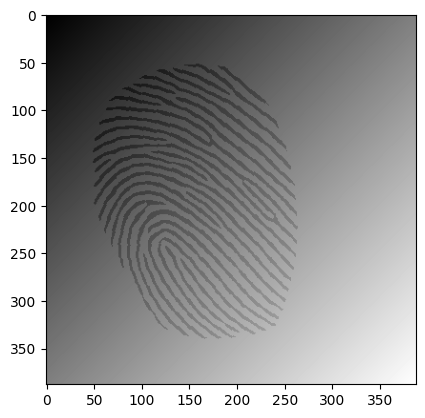

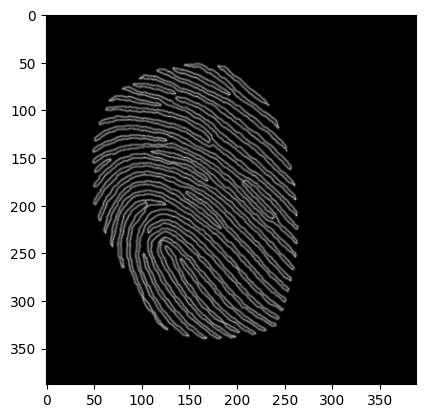

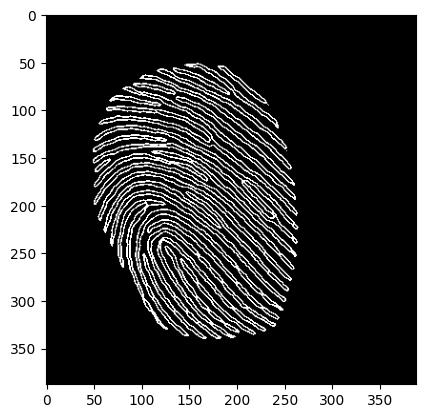

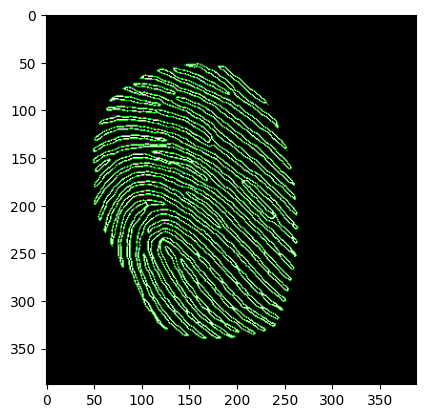

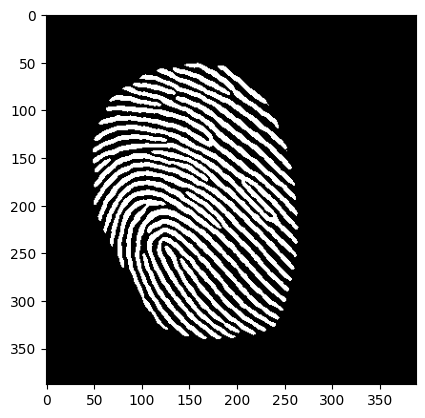

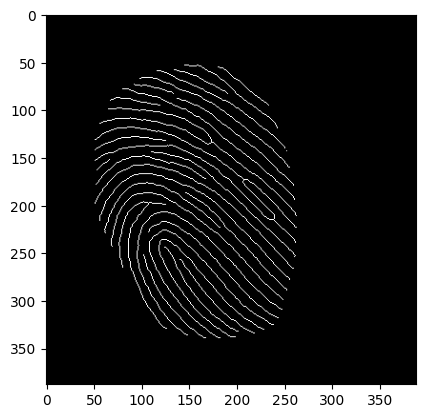

In [93]:
# Correction Image 1
image_path = '../Images_suspects/suspect_1.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image,'gray')
plt.show()

# Correction de l'éclairage
corrected_image = correct_background(image)
plt.imshow(corrected_image,'gray')
plt.show()

_,bin_image = cv2.threshold(corrected_image,80,255,cv2.THRESH_BINARY)
plt.imshow(bin_image,'gray')
plt.show()

contours,__ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
output = cv2.cvtColor(bin_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(output,contours,-1,(0,255,0),1)
plt.imshow(output,'gray')
plt.show()

fill_image = np.zeros_like(corrected_image)
cv2.drawContours(fill_image,contours,-1,255,-1)
plt.imshow(fill_image,'gray')
plt.show()

skel_img = skimage.morphology.thin(fill_image)
plt.imshow(skel_img,'gray')
plt.show()


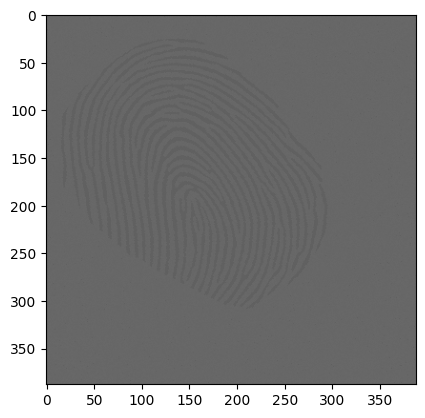

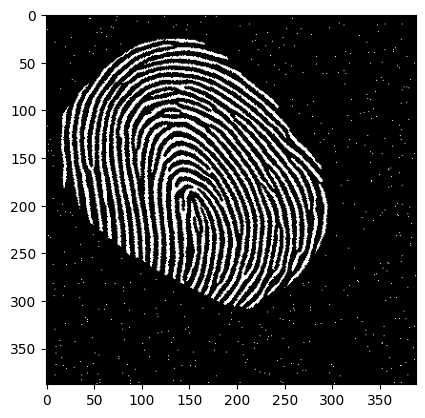

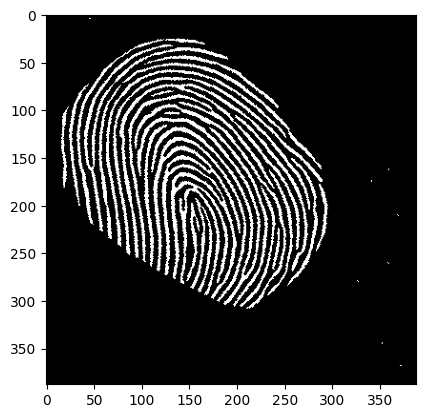

In [163]:
# Correction Image 2
image_path = '../Images_suspects/suspect_2.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image,'gray',vmin=0,vmax=255)
plt.show()

__,bin_image = cv2.threshold(image,100,255,cv2.THRESH_BINARY_INV)
plt.imshow(bin_image,'gray')
plt.show()

kernel = np.array([[-1,-1,-1],
                   [-1, 1,-1],
                   [-1,-1,-1]])

noise = cv2.morphologyEx(bin_image,cv2.MORPH_HITMISS,kernel)
plt.imshow(bin_image-noise,'gray')

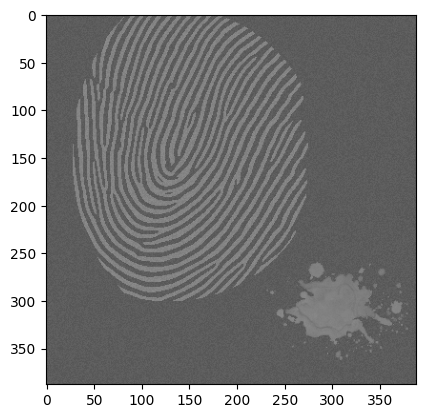

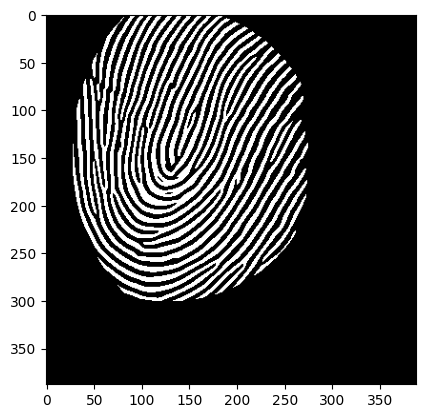

In [80]:
# Correction Image 4
image_path = '../Images_suspects/suspect_4.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image,'gray',vmin=0,vmax=255)
plt.show()

_,bin_image = cv2.threshold(image,100,255,cv2.THRESH_BINARY)
dilate_image = cv2.morphologyEx(bin_image,cv2.MORPH_DILATE,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)))

contours,__ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contours = [cnt for cnt in contours if cv2.contourArea(cnt)>50000]
fingerprint_zone_mask = np.zeros_like(bin_image)
cv2.drawContours(fingerprint_zone_mask,contours,-1,255,-1)

output = np.logical_and(bin_image, fingerprint_zone_mask)
plt.imshow(output,'gray')
plt.show()

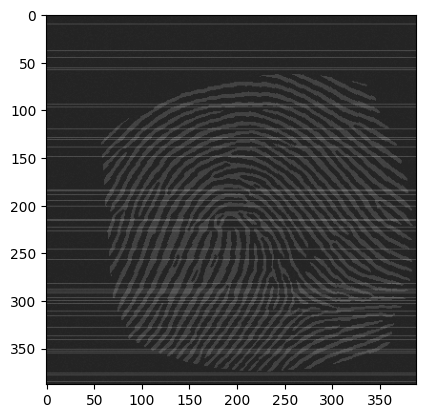

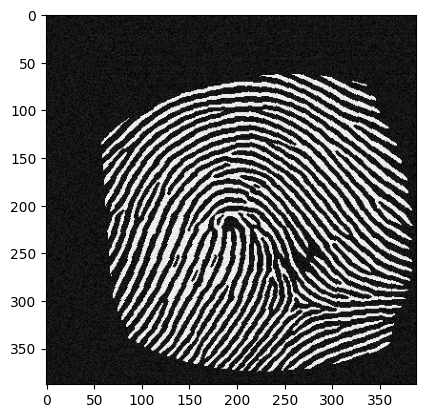

In [92]:
# Correction Image 3
image_path = '../Images_suspects/suspect_3.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image,'gray',vmin=0,vmax=255)
plt.show()

profile_x = np.mean(image[:,:50],axis=1)

output = image - np.repeat(np.expand_dims(profile_x,axis=1),388,axis=1)

plt.imshow(output,'gray')
plt.show()

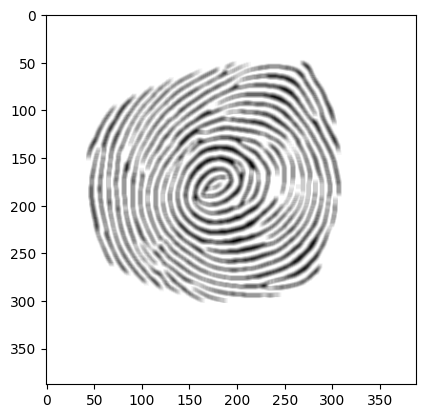

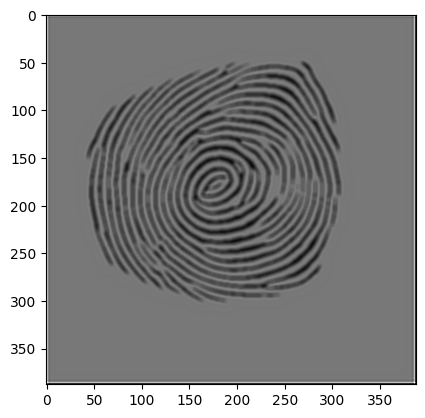

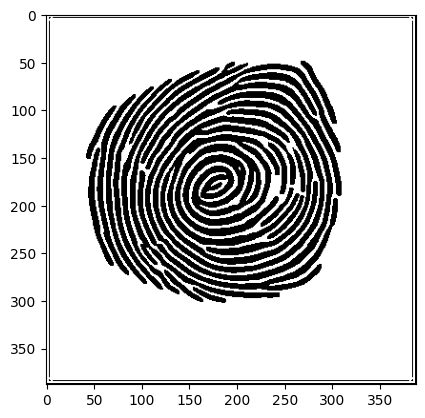

In [174]:
import cv2
import numpy as np
from scipy.signal import convolve2d

def richardson_lucy_deconvolution(image, psf, iterations=10):
    """
    Applique la déconvolution de Richardson-Lucy à une image floue.

    :param image: Image floue en niveaux de gris (numpy array).
    :param psf: Point Spread Function (PSF), ou noyau de flou (numpy array).
    :param iterations: Nombre d'itérations de l'algorithme.
    :return: Image restaurée après déconvolution.
    """
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)
    
    estimate = np.full(image.shape, 0.5, dtype=np.float32)  # Initialisation de l'image estimée

    psf_mirror = psf[::-1, ::-1]  # PSF retournée (utilisée pour la convolution)

    for _ in range(iterations):
        relative_blur = convolve2d(estimate, psf, 'same')
        relative_blur[relative_blur == 0] = 1e-10  # Éviter la division par zéro

        estimate *= convolve2d(image / relative_blur, psf_mirror, 'same')

    return np.clip(estimate, 0, 255).astype(np.uint8)

# Exemple d'utilisation
image = cv2.imread('../Images_suspects/suspect_5.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(image,'gray')
plt.show()

# Noyau de flou (par exemple, un noyau gaussien)
psf_size = 5
psf = cv2.getGaussianKernel(psf_size, 1)
psf = np.outer(psf, psf)

restored_image = richardson_lucy_deconvolution(image, psf, iterations=5)
plt.imshow(restored_image,'gray')
plt.show()

_,bin_image = cv2.threshold(restored_image,140,255,cv2.THRESH_BINARY)
plt.imshow(bin_image,'gray')
plt.show()

In [136]:
np.unique(image)

array([ 95,  96,  97,  99, 100, 101, 102, 103, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 132, 133, 134, 135, 137, 138, 139, 140, 141,
       143, 144, 145, 146, 148, 149, 150], dtype=uint8)